In [1]:
import os
import numpy as np
from scipy.special import logsumexp
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

# %matplotlib inline
%matplotlib notebook
# %pylab inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use("ggplot")

print(tf.__version__)

1.15.0


In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

In [3]:
# Download from https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus/download
# https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede
# To use black-box sk crf:
# https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2

kner_path = os.path.expanduser("~/data/mtwowi/kner")
data = pd.read_csv(os.path.join(kner_path, "ner_dataset.csv"), encoding="latin1")
#data = data.drop(['POS'], axis =1)
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [9]:
# Print tag stats and prepare tag dictionary.
STATE_INIT = 0
tag_name_to_id = dict()
tag_name_to_id["init"] = STATE_INIT
tags_counts = data.groupby('Tag').size().reset_index(name='counts')
for row_num, tag_count_row in tags_counts.iterrows():
    state = len(tag_name_to_id)
    tag = tag_count_row["Tag"]
    #count = tag_count_row["counts"]
    tag_name_to_id[tag] = state
NUM_STATES = len(tag_name_to_id)
tags_counts

,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


<IPython.core.display.Javascript object>


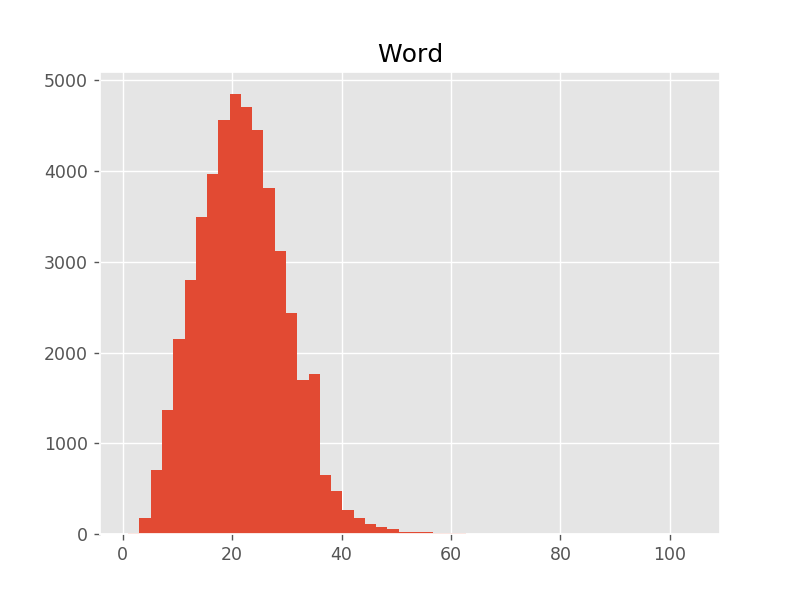

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1da8bc9898>]],
      dtype=object)

In [10]:
# Sentence length histogram.
data.groupby("Sentence #")[["Word"]].count().hist(bins=50)

In [11]:
# Average and max sentence length.
print(data.groupby("Sentence #")[["Word"]].count().mean())
print(data.groupby("Sentence #")[["Word"]].count().max())

Word    21.863988
dtype: float64
Word    104
dtype: int64


In [12]:
# Number of sentences.
sentence_words = data.groupby("Sentence #")[["Word"]].count()
NUM_INST = sentence_words.count()["Word"]
NUM_INST

47959

In [13]:
# Prepare feature dictionary.
word_str_to_id = dict()
for word in data.Word.unique():
    word_str_to_id[word] = len(word_str_to_id)
NUM_FEATURES = len(word_str_to_id)
NUM_FEATURES

35178

In [14]:
import numpy as np

class SentenceScanner(object):
    def __init__(self, num_states, num_features, max_len, batch_size):
        self._num_states = num_states
        self._num_features = num_features
        self._max_len = max_len
        self._batch_size = batch_size
        self._labeled_states = np.zeros((self._batch_size, self._max_len, self._num_states), dtype=np.int8)
        self._labeled_emits = np.zeros((self._batch_size, self._max_len, self._num_features), dtype=np.int8)
        # Also prepare a suffix mask to know where each sequence ended, a (B, T) tensor.
        # This will let us ignore padded positions in the loss expression.
        self._labeled_masks = np.zeros((self._batch_size, self._max_len), dtype=np.int8)
        
    def __iter__(self):
        return self

    def get_batch(self):
        # Collect instances into ndarrays declared above.
        num_sentence = 0
        for _, sentence in data.groupby("Sentence #"):
            num_token = 0
            for _, token in sentence.iterrows():
                xid = word_str_to_id[token["Word"]]
                yid = tag_name_to_id[token["Tag"]]
                self._labeled_masks[num_sentence, num_token] = 1
                self._labeled_emits[num_sentence, num_token, xid] = 1
                self._labeled_states[num_sentence, num_token, yid] = 1
                num_token += 1
                if num_token >= self._max_len:
                    break
            num_sentence += 1
            if num_sentence >= self._batch_size:
                yield (self._labeled_masks, self._labeled_emits, self._labeled_states)
                self._labeled_masks.fill(0)
                self._labeled_emits.fill(0)
                self._labeled_states.fill(0)
                num_sentence = 0
        if num_sentence > 0:
            yield (self._labeled_masks, self._labeled_emits, self._labeled_states)


# Clip at max sequence length T (starting with STATE_INIT).
MAX_LEN = 45
# M states, N instances (sentences), F features.
# Convert training instances into [N, T, M] states tensor and [N, T, F] emission tensor.
# We will generally not be able to hold all this in RAM, so we use batches.
BATCH_SIZE = 51

# TODO  Add code to shuffle sentences randomly and sample into train, dev, test folds.

num_sentences = 0
with tqdm(total=NUM_INST) as pbar:
    ss = SentenceScanner(NUM_STATES, NUM_FEATURES, MAX_LEN, BATCH_SIZE)
    for (_masks, _emits, _states) in ss.get_batch():
        num_sentences += _masks.shape[0]
        pbar.update(BATCH_SIZE)
print(num_sentences)

47991it [02:06, 380.05it/s]                           

47991


<tf.Variable 'nodew:0' shape=(18, 35178) dtype=float64_ref>
<tf.Variable 'edgew:0' shape=(18, 18) dtype=float64_ref>
Tensor("masks:0", shape=(51, 45), dtype=float64)
Tensor("emits:0", shape=(51, 45, 35178), dtype=float64)
Tensor("states:0", shape=(51, 45, 18), dtype=float64)
Tensor("prev_states:0", shape=(51, 45, 18), dtype=float64)
Tensor("var1/Reshape_1:0", shape=(51, 45, 18), dtype=float64)
Tensor("var2:0", shape=(51, 45, 18, 1), dtype=float64)
Tensor("var3:0", shape=(51, 45, 18, 18), dtype=float64)
Tensor("var4:0", shape=(1, 18, 18), dtype=float64)
Tensor("var5:0", shape=(45, 18, 18), dtype=float64)
Tensor("var6:0", shape=(1, 45, 18, 18), dtype=float64)
Tensor("var7:0", shape=(51, 45, 18, 18), dtype=float64)
Tensor("wvarphi_t:0", shape=(51, 45, 18, 18), dtype=float64)
Tensor("scores_t/Reshape_4:0", shape=(51, 45), dtype=float64)
Tensor("scores:0", shape=(51,), dtype=float64)
<tf.Variable 'lalpha_0:0' shape=(51, 18) dtype=float64_ref>
Instructions for updating:
Use tf.where in 2.0, 

<IPython.core.display.Javascript object>


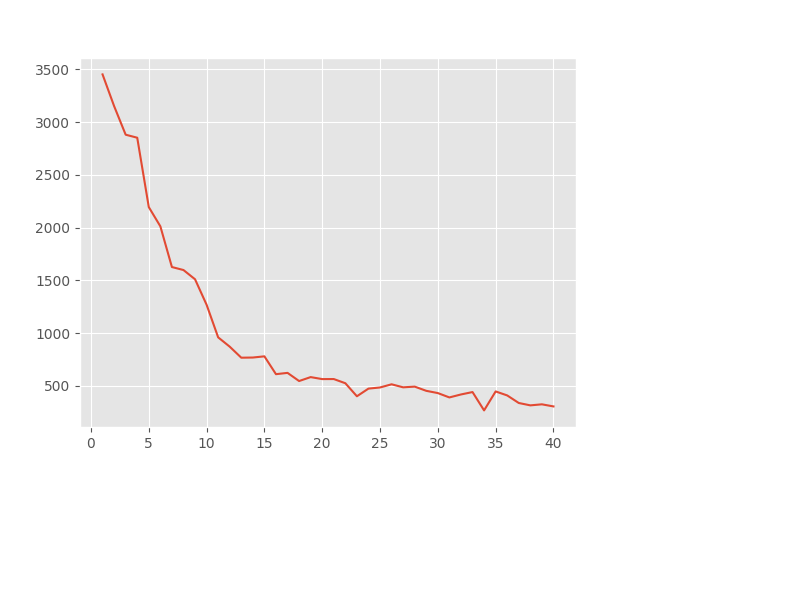

   305.181:   4%|▍         | 2040/47991 [01:26<30:27, 25.15it/s]

In [ ]:
class ChainCRF(object):
    """Implements linear chain CRF."""
    def __init__(self, state_init, num_states, num_features, max_len, batch_size):
        self._num_states = num_states
        self._num_features = num_features
        self._max_len = max_len
        self._batch_size = batch_size
        # Trainable transition weights.  Rows = current state, columns = previous state.
        self._edgew = tf.Variable(tf.random_uniform([self._num_states, self._num_states], 
                                                     dtype=tf.float64, minval=-1., maxval=1.),
                                   trainable=True, name="edgew")   #  (M, P)
        # Trainable emission weights.  For starters we will use only lexicalized features.
        self._nodew = tf.Variable(tf.random_uniform([self._num_states, self._num_features],
                                                     dtype=tf.float64, minval=-1., maxval=1.),
                                   trainable=True, name="nodew")   #  (M, F)
        # Labeled instances.
        # Features may not be 1-hot in general. 1-hot state rep may be wasteful.
        self._masks = tf.placeholder(tf.float64, shape=(self._batch_size, self._max_len),
                                     name="masks")   #  (B, T)
        self._emits = tf.placeholder(tf.float64, shape=(self._batch_size, self._max_len,
                                                        self._num_features), name="emits")  # (B, T, F)
        self._states = tf.placeholder(tf.float64, shape=(self._batch_size, self._max_len,
                                                         self._num_states), name="states")  # (B, T, M)
        self._pad_states_np = np.zeros((self._batch_size, 1, self._num_states))
        self._pad_states_np[:,:, state_init] = 1
        pad_states = tf.constant(self._pad_states_np, dtype=tf.float64)
        self._prev_states = tf.concat([pad_states, self._states[:,:-1,:] ],
                                      axis=1, name="prev_states") # (B, T, P)
        # P = M but we use a distinct symbol to highlight the distinction between previous and current states.
        print(self._nodew)
        print(self._edgew)
        print(self._masks)
        print(self._emits)
        print(self._states)
        print(self._prev_states)

        # To look up w \cdot \varphi(x_t, m, p) for all instances in the batch, we need
        # corresponding tensor wvarphi_t with shape (B, T, M, P).
        # We want wvarphi_t[b, t, p, m] =  ( sum_f nodew[m, f] emits[b, t, f] ) + edgew[p, m]
        # for all possible combinations of m, p in [M] \times [P], not just the gold sequence.
        # The first term results in shape (B, T, M) and the second term results in shape (M, P).
        # These have to be expanded to shape (B, T, M, P).

        var1 = tf.einsum("btf,mf->btm", self._emits, self._nodew, name="var1")  # .... (B, T, M)
        print(var1)
        var2 = tf.expand_dims(var1, axis=3, name="var2")    #  .... (B, T, M, 1)
        print(var2)
        var3 = tf.tile(var2, [1, 1, 1, self._num_states], name="var3")   # .... (B, T, M, P)
        print(var3)

        # edge_weights is (M, P)
        var4 = tf.expand_dims(self._edgew, axis=0, name="var4")   #  (1, M, P)
        print(var4)
        var5 = tf.tile(var4, [self._max_len, 1, 1], name="var5")   #  (T, M, P)
        print(var5)
        var6 = tf.expand_dims(var5, axis=0, name="var6")   #  (1, T, M, P)
        print(var6)
        var7 = tf.tile(var6, [self._batch_size, 1, 1, 1], name="var7")   # ... (B, T, M, P)
        print(var7)

        self._wvarphi_t = tf.add(var3, var7, name="wvarphi_t")    # .... (B, T, M, P)
        print(self._wvarphi_t)
        
        # For given emissions and state labels, find score w \cdot \phi(x, y).
        self._scores_t = tf.einsum("btmp,btp,btm->bt", self._wvarphi_t,
                                   self._prev_states, self._states, name="scores_t")  #  (B,T)
        print(self._scores_t)
        self._scores = tf.reduce_sum(tf.multiply(self._scores_t, self._masks),
                                     axis=1, name="scores")    #  ... (B)
        print(self._scores)
        
        # Alpha recurrence over time steps.
        self._lalpha = tf.Variable(initial_value=np.zeros((self._batch_size, self._num_states)),
                                  trainable=True, name="lalpha_0")   # .... (B, M)
        print(self._lalpha)
        for t in range(self._max_len):
            var8 = tf.tile(tf.expand_dims(self._lalpha, axis=1), [1, self._num_states, 1])  #  (B, M, P)
            next_lalpha = tf.reduce_logsumexp(var8 + self._wvarphi_t[:,t,:,:],  # (B, M, P)
                                              axis=2, name="lalpha_"+str(t+1))
            mask_t = tf.tile(tf.expand_dims(self._masks[:,t], axis=1), [1, self._num_states])
            self._lalpha = tf.multiply(mask_t, next_lalpha) + tf.multiply(1.-mask_t, self._lalpha)
        print(self._lalpha)
        
        # For given emissions, find log Z over all possible state label sequences.
        self._logz = tf.reduce_logsumexp(self._lalpha, axis=1, name="logz")   # ... (B)
        print(self._logz)
        # We have to maximize scores - logZ i.e. minimize logZ - score.
        self._loss = tf.reduce_sum(self._logz - self._scores, name="loss")    # ... (B)
        print(self._loss)
        adamopt = tf.train.AdamOptimizer(learning_rate=0.1)
        self._train_op = adamopt.minimize(self._loss, var_list=[self._nodew, self._edgew])

        
    def check_np_scores(self, sess, masks, emitss, statess):
        """
        masks, emitss, statess are for a whole batch.
        Calculates w \cdot \phi conventionally using numpy to check correctness.
        """
        _nodew = sess.run(self._nodew)
        _edgew = sess.run(self._edgew)
        ans = np.zeros((self._batch_size))
        for b in range(self._batch_size):
            mask = masks[b,:]
            emits = emitss[b,:,:]
            states = statess[b,:,:]
            prev_states = np.concatenate((self._pad_states_np[b,:,:], states[:-1,:]), axis=0)
            potscore = 0
            for t in range(self._max_len):
                aemit = emits[t,:]
                aprev_state = prev_states[t,:]
                astate = statess[b,t,:]
                nodepot = np.matmul(astate, np.matmul(_nodew, aemit))
                edgepot = np.matmul(astate, np.matmul(_edgew, aprev_state))
                potscore += (nodepot + edgepot)
            ans[b] = potscore
        return ans
    
    def check_tf_scores(self, sess, masks, emitss, statess):
        tf_scores = sess.run(self._scores, feed_dict = {
            self._masks: masks, self._emits: emitss, self._states: statess })
        return tf_scores

    def check_np_logzs(self, sess, masks, emitss, statess):
        """
        Calculates log Z conventionally using numpy to check correctness.
        """
        np_wvarphi_t = sess.run(self._wvarphi_t, feed_dict={
            self._masks: masks, self._emits: emitss, self._states: statess})
        #print("np_wvarphi_t", np_wvarphi_t.shape)   # (B, T, M, P)
        logzs = np.zeros((self._batch_size))
        for b in range(self._batch_size):
            np_lalpha = np.zeros((self._num_states))  # (P) or (M)
            for t in range(self._max_len):
                np_lalpha_next = np.zeros((self._num_states))  # (M)
                for m in range(self._num_states):
                    softsummand = np.zeros((self._num_states))  # (P)
                    for p in range(self._num_states):
                        softsummand[p] = np_wvarphi_t[b,t,m,p] + np_lalpha[p]
                    np_lalpha_next[m] = logsumexp(softsummand)
                np_lalpha = np_lalpha_next
            logzs[b] = logsumexp(np_lalpha)
        return logzs

    def check_tf_logzs(self, sess, masks, emitss, statess):
        tf_logzs = sess.run(self._logz, feed_dict={
            self._masks: masks, self._emits: emitss, self._states: statess})
        return tf_logzs

    def do_train(self, sess, num_epochs=10):
        sess.run(tf.global_variables_initializer())
        # TODO Add code to load any partially trained model for warm-start.
        chart_batches, chart_losses = list(), list()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        #plt.ion()
        fig.show()
        fig.canvas.draw()
        num_batches = 0
        # TODO keep history of loss objectives
        for _ in range(num_epochs):
            with tqdm(total=num_sentences) as pbar:
                ss = SentenceScanner(self._num_states, self._num_features, self._max_len, self._batch_size)
                for (masks, emits, states) in ss.get_batch():
                    num_batches += 1
                    sess.run(self._train_op, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _logZ = sess.run(self._logz, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _scores = sess.run(self._scores, feed_dict = { 
                        self._masks: masks, self._emits: emits, self._states: states })
                    _loss = np.sum(_logZ - _scores)
                    assert _loss >= 0

                    chart_batches.append(num_batches)
                    chart_losses.append(_loss)
                    ax.clear()
                    ax.plot(chart_batches, chart_losses)
                    fig.canvas.draw()
                    pbar.update(self._batch_size)
                    pbar.set_description("%10g" % _loss)
                    
                    if np.min(_logZ - _scores) < 0:
                        print("tf_logzs - tf_scores", _logZ - _scores)
                        np_scores = self.check_np_scores(sess, masks, emits, states)
                        tf_scores = self.check_tf_scores(sess, masks, emits, states)
                        print("np_scores - tf_scores", np.linalg.norm(np_scores - tf_scores, ord=np.inf))
                        np_logzs = ccrf.check_np_logzs(sess, masks, emits, states)
                        tf_logzs = ccrf.check_tf_logzs(sess, masks, emits, states)
                        print("np_logzs - tf_logzs", np.linalg.norm(np_logzs - tf_logzs, ord=np.inf))
                        return
            # TODO Add code to decide on ending training, saving model checkpoints.
            
    def get_fold_performance():
        """TODO Add code to calculate best labels sequences for current model, compare with gold
        sequences, and return a measure of performance."""
        pass


ccrf = ChainCRF(STATE_INIT, NUM_STATES, NUM_FEATURES, MAX_LEN, BATCH_SIZE)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    ccrf.do_train(sess)

In [43]:
# Also see https://github.com/tensorflow/addons/blob/1bbe67ff075040eb54a468a3993dd36a0a5689c3/tensorflow_addons/text/crf.py#L121